In [16]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from options import *
from constants import *
import tifffile

from scipy.signal import convolve2d

# légerement mieux que plt (mais c'est basé sur plt bien sur) et permet de rajouter une scalebar 
# import microfilm.microplot as microplt

# import mpl_scatter_density # pas utile pour nos données


nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [17]:
p = plt.rcParams
p['axes.grid'] = False
p['xtick.bottom'] = False
p['xtick.labelbottom'] = False
p['ytick.left'] = False
p['ytick.labelleft'] = False

In [18]:
# id,frame,x [nm],y [nm],sigma [nm],intensity [photon],amplitude [photon],offset [photon],bkgstd [photon],uncertainty_xy [nm]
id, frame, x, y, sigma, intensity, amplitude, offset, bkgstd, uncertainty_xy = np.loadtxt("../data/microtubules/Acquisition-1/CoordTable_SAFE180_2D.csv",
                                                                                          unpack=True, delimiter=',', skiprows=1)

Pas utile pour nos données

In [19]:
# def using_mpl_scatter_density(fig, x, y):
#     ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
#     density = ax.scatter_density(x, y, cmap='inferno')
#     fig.colorbar(density, label='Number of points per pixel')

# fig = plt.figure()
# using_mpl_scatter_density(fig, x, y)
# plt.show()

Interesting: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density
In the end wasn't that useful

Approach which was actually used in research: https://colab.research.google.com/drive/14OCvRUAUFp9JXK6HVyj18fndGY92-Dsx?usp=sharing#scrollTo=6SvsgDkeuXph

Ou sinon on utilise le TIFF

In [20]:
pixel_recon_dim = 5

# We find the minimum X and Y values in our dataset. They will be used to shift
# all data points to the left or up.
min_x = np.floor(np.min(x))
min_y = np.floor(np.min(y))
x -= min_x
y -= min_y

# We determine the maximum X and Y coordinates to generate proper histograms.
min_x = 0
min_y = 0
max_x = np.ceil(np.max(x))
max_y = np.ceil(np.max(y))

hist_original = np.histogram2d(x,y, range=[[min_x, max_x], [min_y, max_y]],
                                    bins=[int(max_x/pixel_recon_dim), int(max_y/pixel_recon_dim)],
                                    weights=intensity)

# Convolution kernels are two dimensional arrays (here 3x3 and 5x5)
# by which we will possibly convolve the two-dimensional histogram later.
kernel_3x3 = [
    [0,1,0],
    [1,2,1],
    [0,1,0]
]

kernel_5x5 = [
    [0,0,1,0,0],
    [0,1,2,1,0],
    [1,2,3,2,1],
    [0,1,2,1,0],
    [0,0,1,0,0]
]

# To convolve the histogram with one of the kernels we use the convolve2d
# function from the SciPy library. The output has the same dimensions as the
# original histogram due to specifying the convolution mode to 'same'
histogram_convolved = convolve2d(hist_original[0], kernel_3x3, mode='same')
H, W = np.shape(histogram_convolved.T)


In [21]:
print(H,W)

15776 15783


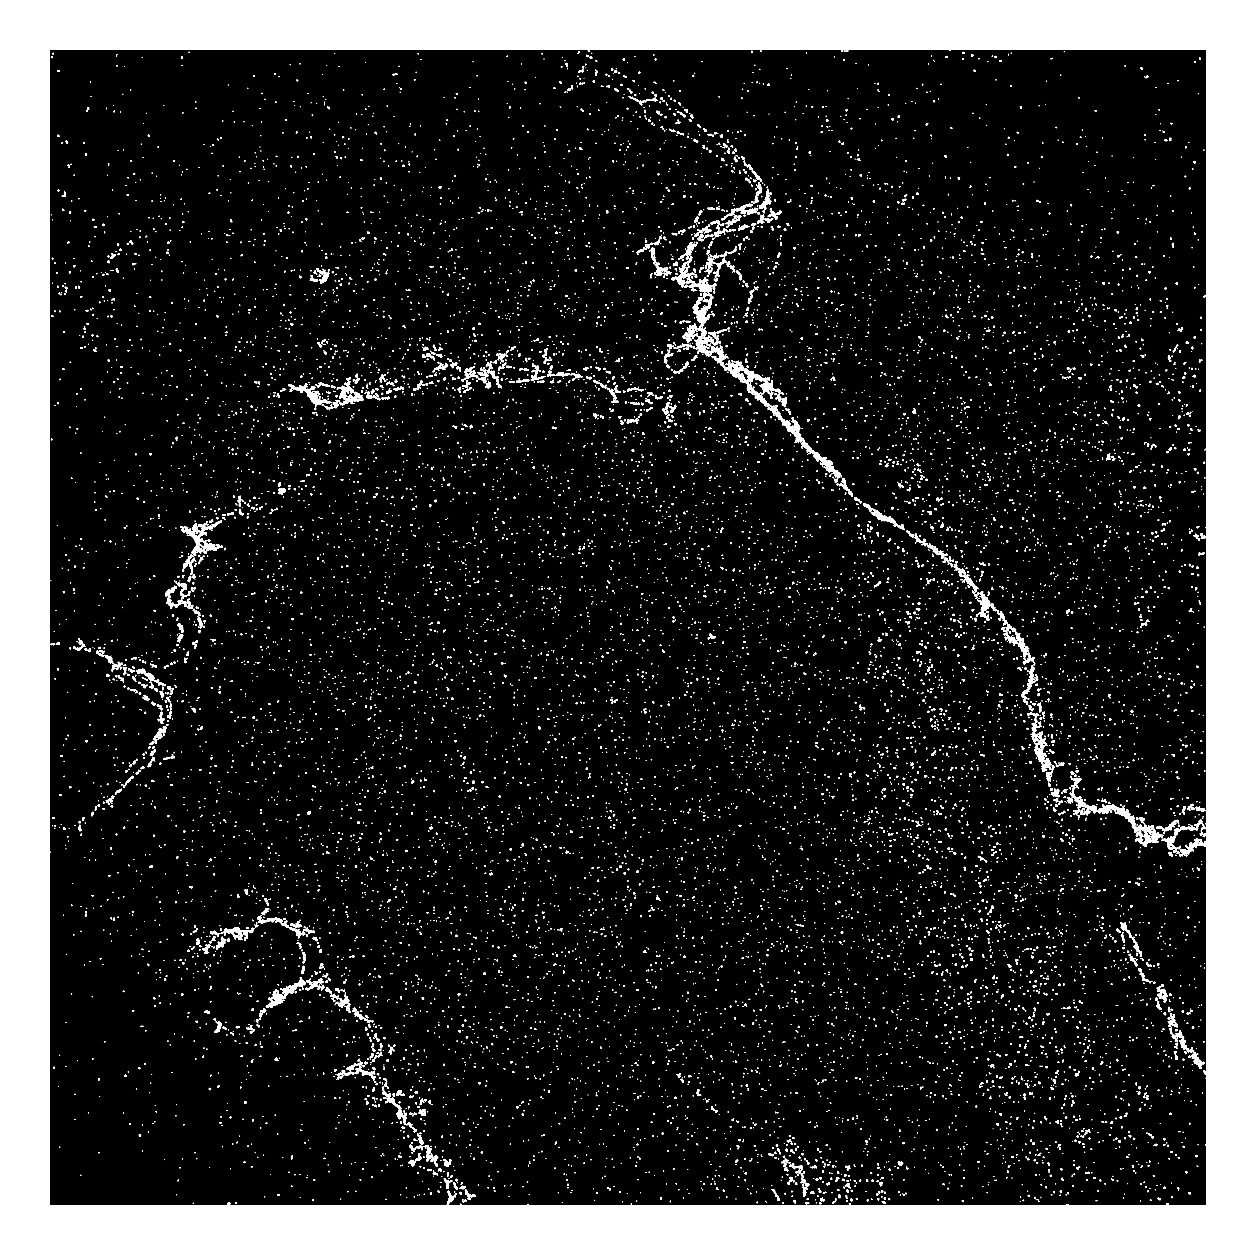

In [27]:
# The result of the convolved histogram is plotted.
plt.figure(figsize=(3,3), dpi=500)
plt.imshow(histogram_convolved.T, vmax=10, cmap='Greys_r')
plt.axis('off')
plt.savefig("../figures/test_convolution.pdf")

Still have to try the linear interpolation, seems to give interesting images.

Le scatter marche mais pas une bonne idée

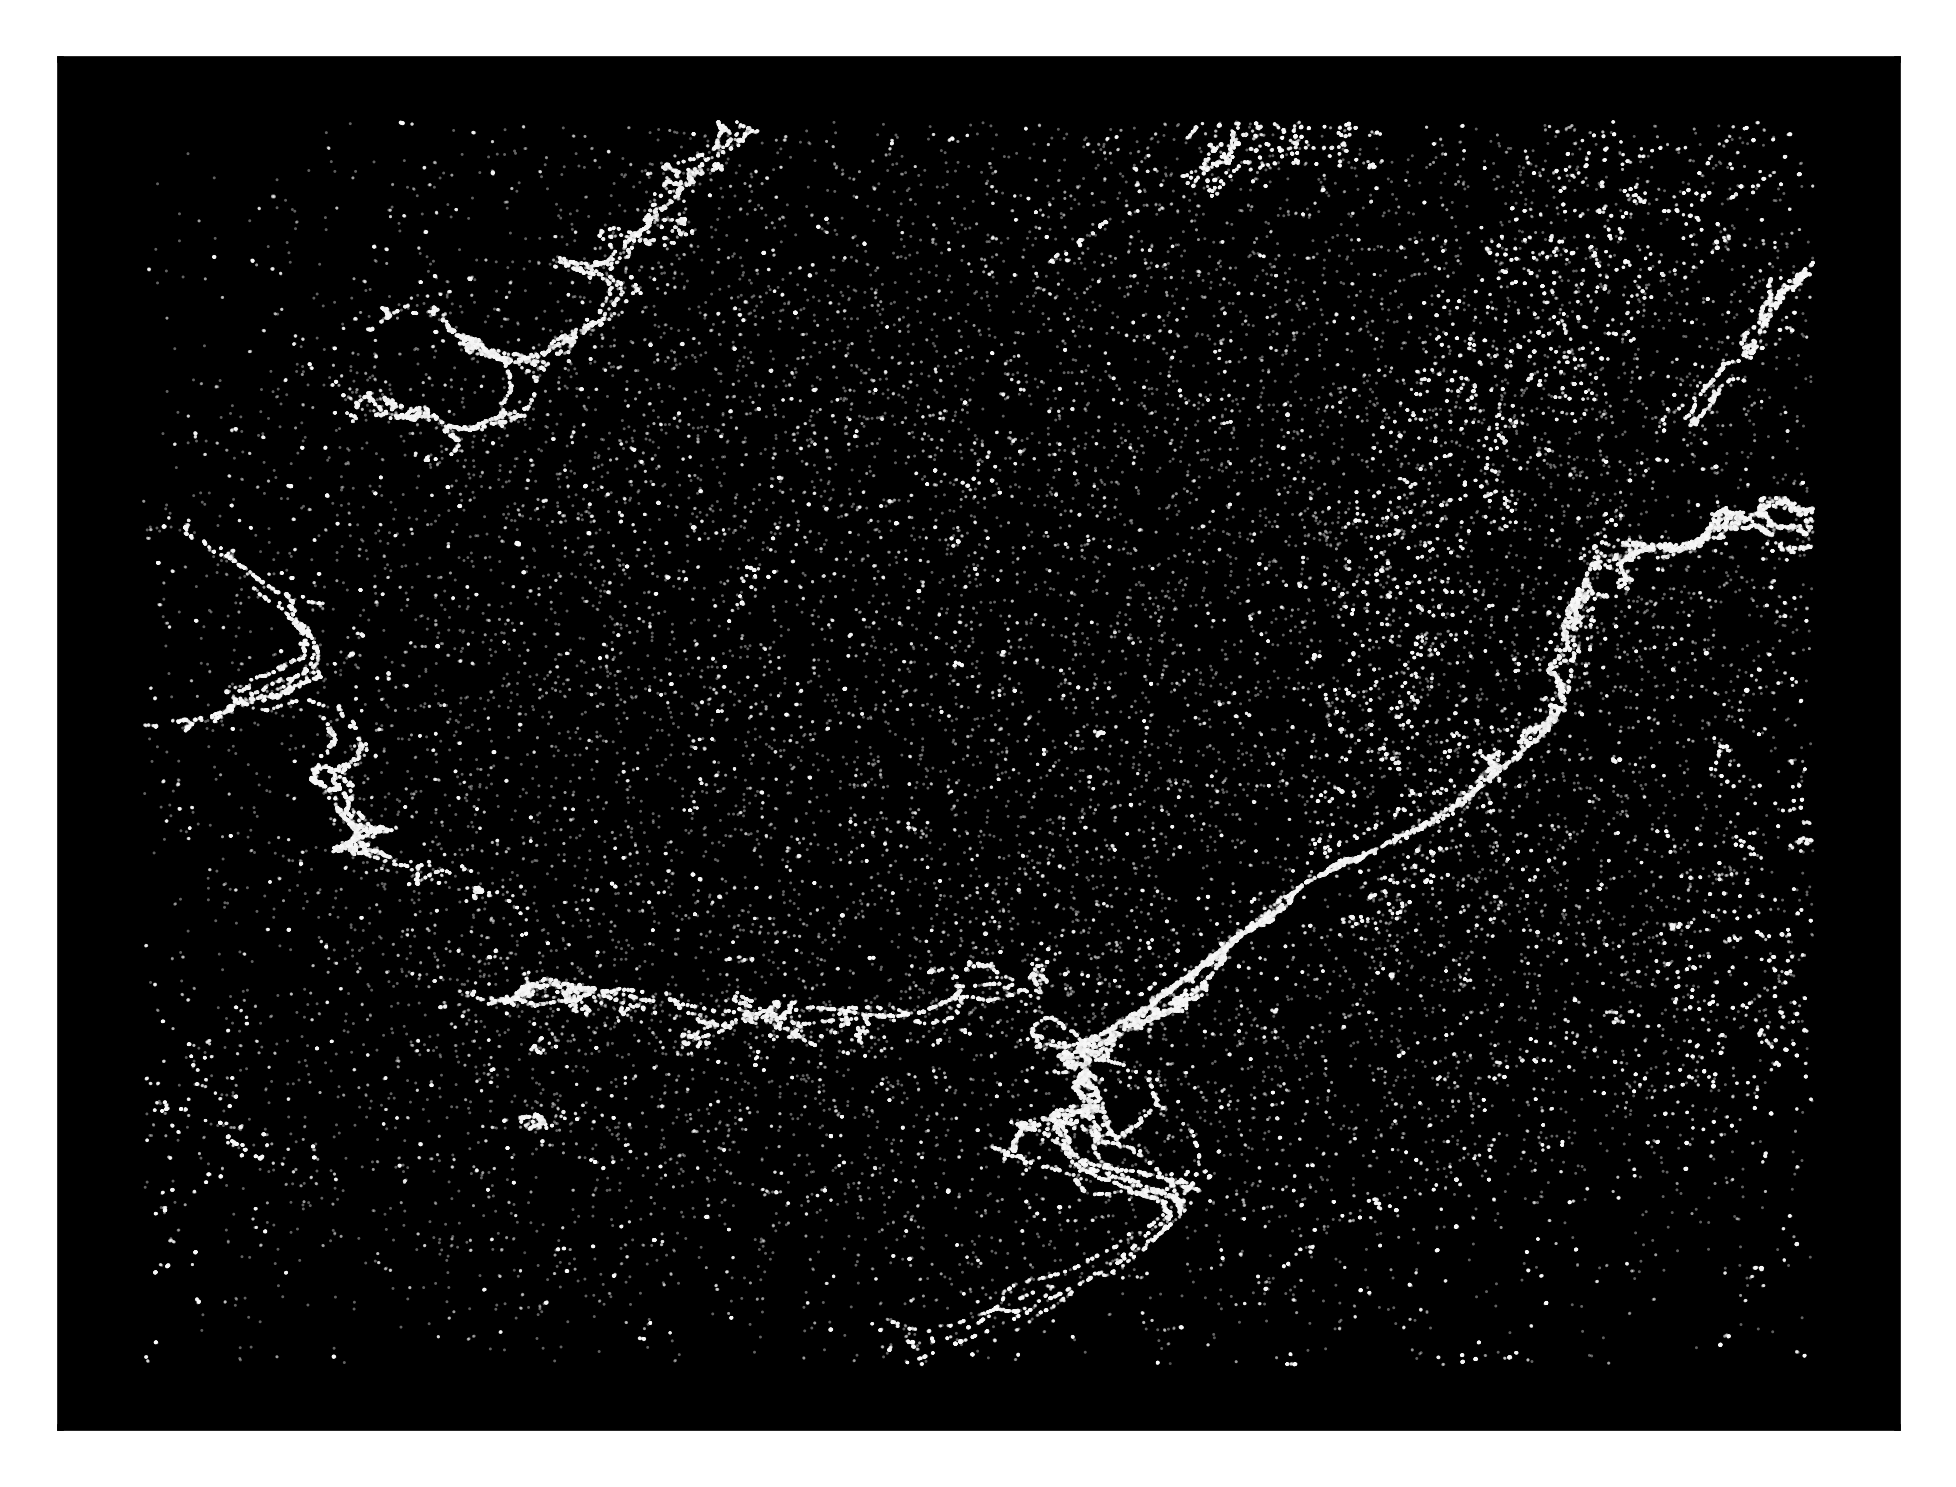

In [23]:
fig, ax = plt.subplots(dpi=600)
plt.scatter(x,y, marker='.', s=0.5, alpha=0.4, edgecolors='none',
            c=intensity, cmap='Greys')
ax.set_facecolor('black')
# plt.savefig("../figures/test2.png")
plt.show()

Le TIFF n'est pas trop mal au final

In [24]:
imdata = tifffile.imread('../data/microtubules/Acquisition-5/NANO2D_pix_15nm.tif')
pix_min = np.min(imdata)
pix_max = np.max(imdata)
normalized_imdata = (imdata - pix_min) / (pix_max - pix_min)
# print(np.mean(normalized_imdata))
# # print(pix_min)
# print(pix_max)
# # print(np.max(normalized_imdata))
# np.sum(normalized_imdata > 0.01)

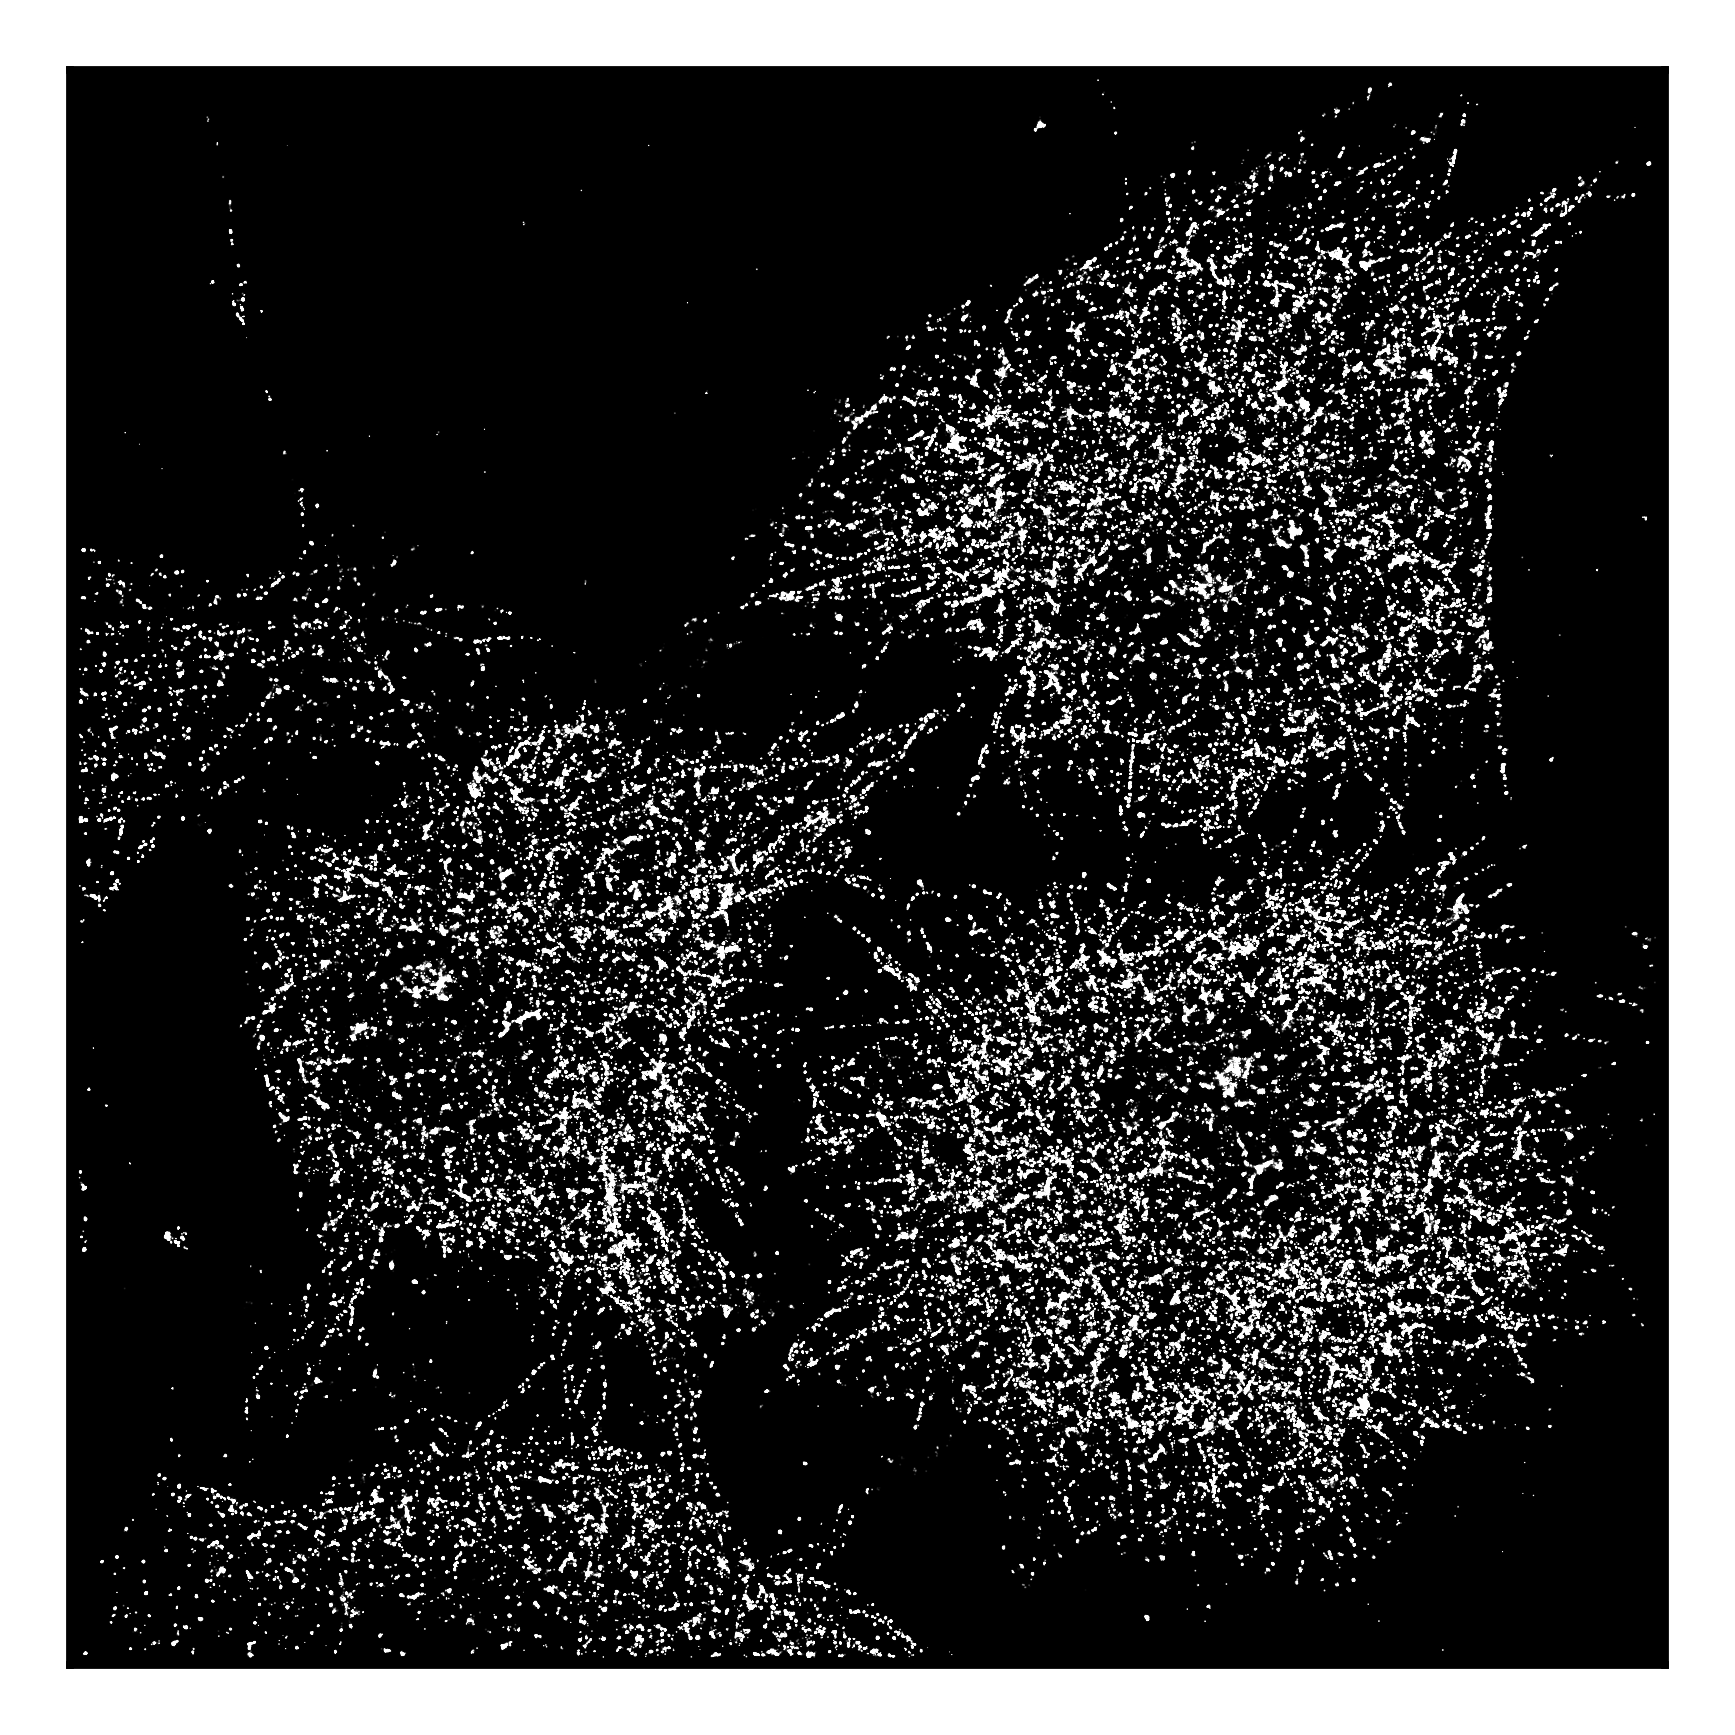

In [25]:
plt.figure(dpi=700)
plt.imshow(normalized_imdata, cmap=plt.get_cmap('Greys_r'),
           vmax=0.0002)
# plt.colorbar()
plt.grid(False)
plt.savefig("../figures/test.pdf")
plt.show()


Ca c'est le TIFF legerement plus beau

In [26]:
# microim = microplt.microshow(normalized_imdata, limits=[0,0.0007])
# microplt.savefig("../figures/micro.pdf", dpi=700)
